Check the quality of spike train generation and augmentation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen, arb_spk_gen

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')

In [4]:
data[data['ptl_idx']==3]

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste
79,3,2,0,2,0,60,1.0,5.0,-115.614439,-5,8.242655,0.0
80,3,2,0,2,0,60,1.0,5.0,-115.514279,-5,-8.423933,0.0
81,3,2,0,2,0,60,1.0,5.0,-104.513200,-5,0.996460,0.0
82,3,2,0,2,0,60,1.0,5.0,-82.919929,-5,7.876141,0.0
83,3,2,0,2,0,60,1.0,5.0,-93.891549,-5,-6.446189,0.0
84,3,2,0,2,0,60,1.0,5.0,-71.790409,-5,-4.075914,0.0
85,3,2,0,2,0,60,1.0,5.0,-61.227676,-5,-1.714688,0.0
86,3,2,0,2,0,60,1.0,5.0,-50.201851,-5,3.588077,0.0
87,3,2,0,2,0,60,1.0,5.0,-50.195960,-5,2.607689,0.0
88,3,2,0,2,0,60,1.0,5.0,-50.631949,-5,-4.843633,0.0


In [5]:
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


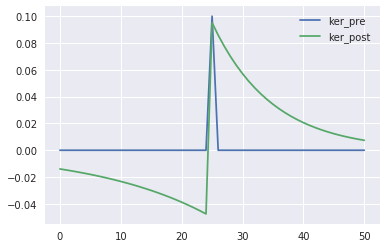

In [6]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen(scale_left=0.05, scale_right=0.1, tau_left=40, tau_right=20, scale=0.1)
plt.plot(ker_test.dot_ker, label='ker_pre')
plt.plot(ker_test.bilat_ker, label='ker_post')
plt.legend()

In [7]:
# Generate data
ptl_list = [1]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=10)

In [8]:
input_stdp =np.load('/data/STDP_toy_input.npy')

In [9]:
input_stdp.shape

(500, 30000, 2)

In [10]:
spk_pairs.shape

(450, 30000, 2)

In [11]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    loci_pre.append(loci_pre_tmp)
    loci_post.append(loci_post_tmp)
    dt_mean.append(np.mean(loci_pre_tmp - loci_post_tmp))

sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

In [12]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(input_stdp[i,:,0]==1)[0]
    loci_post_tmp = np.where(input_stdp[i,:,1]==1)[0]
    loci_pre.append(loci_pre_tmp)
    loci_post.append(loci_post_tmp)
    dt_mean.append(np.mean(loci_pre_tmp - loci_post_tmp))
    
sort_index = np.argsort(dt_mean)
loci_pre_1 = [loci_pre[i] for i in sort_index]
loci_post_1 = [loci_post[i] for i in sort_index]

In [13]:
def raster(event_times_list, trial_length,  **kwargs):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial[trial_length]*2, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


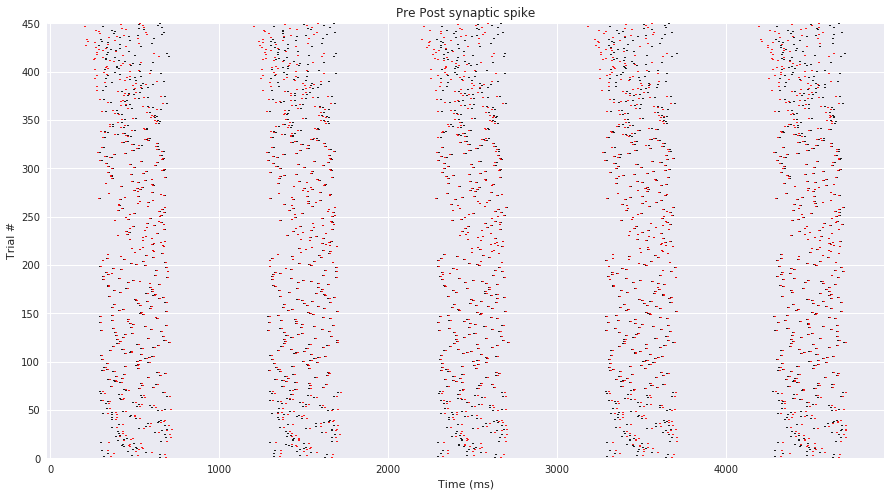

In [14]:
fig = plt.figure(figsize=(15, 8))
trial_length = np.arange(0,5)
ax = raster(loci_pre_1, trial_length)
ax = raster(loci_post_1,trial_length, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
fig.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


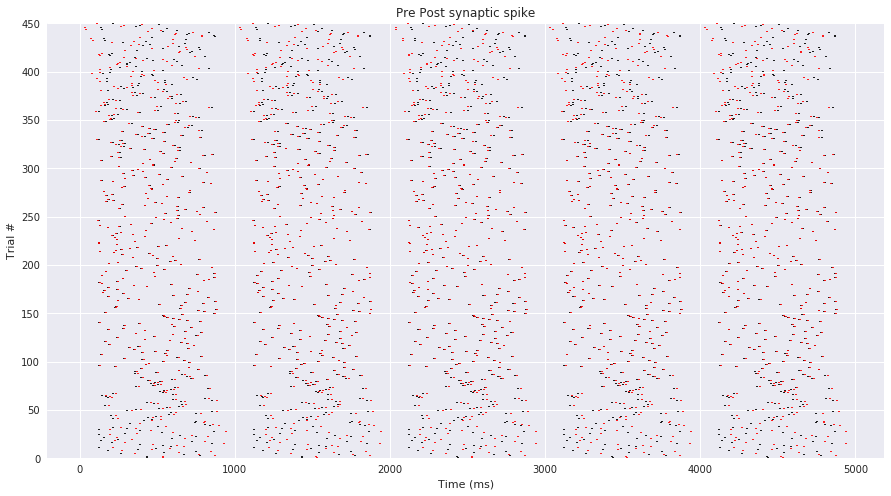

In [15]:
fig = plt.figure(figsize=(15, 8))
trial_length = np.arange(0,5)
ax = raster(loci_pre_2, trial_length)
ax = raster(loci_post_2,trial_length, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
fig.show()

In [16]:
# Generate data
ptl_list = [2,4]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=10)
spk_pairs.shape

(380, 30000, 2)

In [17]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    if len(loci_pre_tmp) == len(loci_post_tmp) * 2:   # Pre-post-pre
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_pre = np.arange(0,len(loci_pre_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp - loci_pre_tmp[index_pre]))
    elif len(loci_post_tmp) == len(loci_pre_tmp) * 2:   # Post-pre-post
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_post = np.arange(0,len(loci_post_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_post] - loci_pre_tmp))
    else:
        print('Wrong length!!')
        
sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


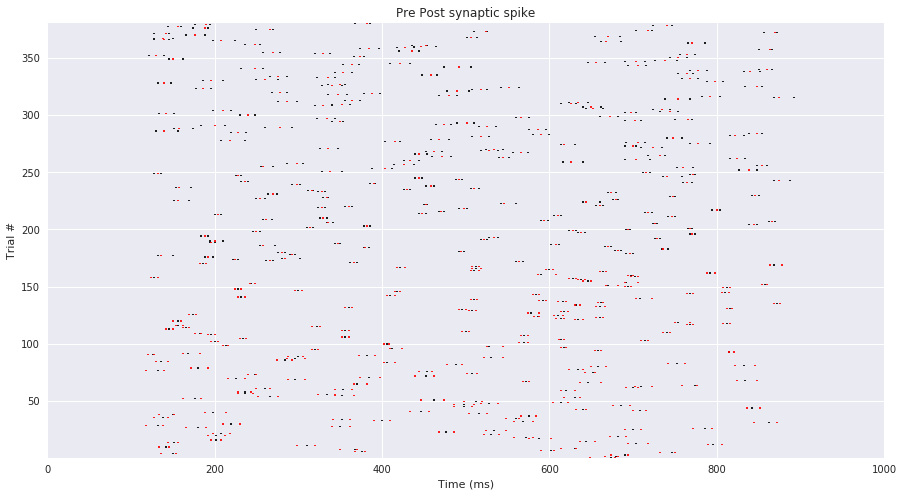

In [18]:
fig = plt.figure(figsize=(15, 8))
trial_length1 = np.arange(0,10)
trial_length2 = np.arange(0,5)
ax = raster(loci_pre_2, trial_length1)
ax = raster(loci_post_2, trial_length2, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
plt.xlim([0,1000])
fig.show()

In [19]:
input_stdp =np.load('/data/Triplet_toy_input.npy')
input_stdp.shape
# input_quad = np.load('/data/Quad_toy_input.npy')b

(500, 30000, 2)

In [20]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(input_stdp.shape[0]):
    loci_pre_tmp = np.where(input_stdp[i,:,0]==1)[0]
    loci_post_tmp = np.where(input_stdp[i,:,1]==1)[0]
    if len(loci_pre_tmp) > len(loci_post_tmp):   # Pre-post-pre
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_pre = np.arange(0,len(loci_pre_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp - loci_pre_tmp[index_pre]))
    else:  # Post-pre-post
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_post = np.arange(0,len(loci_post_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_post] - loci_pre_tmp))
   
sort_index = np.argsort(dt_mean)
loci_pre_1 = [loci_pre[i] for i in sort_index]
loci_post_1 = [loci_post[i] for i in sort_index]

In [ ]:
fig = plt.figure(figsize=(15, 8))
trial_length1 = np.arange(0,10)
trial_length2 = np.arange(0,5)
ax = raster(loci_pre_1, trial_length1)
ax = raster(loci_post_1, trial_length2, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
plt.xlim([0,1000])
fig.show()

In [21]:
# Generate data
ptl_list = [3]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=10)
spk_pairs.shape

(600, 30000, 2)

In [27]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
# spk_pairs.shape[0]
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    if loci_pre_tmp[0] < loci_post_tmp[0]:  # Pre-post-post-pre
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_pre = np.arange(0,len(loci_pre_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_pre+1] - loci_pre_tmp[index_pre]) * -1)
    elif loci_pre_tmp[0] > loci_post_tmp[0]:   # Post-pre-pre-post
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_post = np.arange(0,len(loci_post_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_post+1] - loci_post_tmp[index_post]))
        
sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

In [28]:
loci_post_tmp 

array([  316,   319,   816,   819,  1316,  1319,  1816,  1819,  2316,
        2319,  2816,  2819,  3316,  3319,  3816,  3819,  4316,  4319,
        4816,  4819,  5316,  5319,  5816,  5819,  6316,  6319,  6816,
        6819,  7316,  7319,  7816,  7819,  8316,  8319,  8816,  8819,
        9316,  9319,  9816,  9819, 10316, 10319, 10816, 10819, 11316,
       11319, 11816, 11819, 12316, 12319, 12816, 12819, 13316, 13319,
       13816, 13819, 14316, 14319, 14816, 14819, 15316, 15319, 15816,
       15819, 16316, 16319, 16816, 16819, 17316, 17319, 17816, 17819,
       18316, 18319, 18816, 18819, 19316, 19319, 19816, 19819, 20316,
       20319, 20816, 20819, 21316, 21319, 21816, 21819, 22316, 22319,
       22816, 22819, 23316, 23319, 23816, 23819, 24316, 24319, 24816,
       24819, 25316, 25319, 25816, 25819, 26316, 26319, 26816, 26819,
       27316, 27319, 27816, 27819, 28316, 28319, 28816, 28819, 29316,
       29319, 29816, 29819])

In [29]:
loci_pre_tmp

array([  312,   322,   814,   822,  1315,  1321,  1815,  1819,  2316,
        2322,  2812,  2821,  3314,  3321,  3814,  3820,  4314,  4320,
        4815,  4821,  5314,  5321,  5814,  5821,  6313,  6321,  6814,
        6821,  7314,  7322,  7814,  7822,  8315,  8322,  8815,  8821,
        9315,  9321,  9813,  9821, 10314, 10321, 10815, 10823, 11316,
       11320, 11814, 11821, 12314, 12322, 12814, 12820, 13315, 13320,
       13814, 13821, 14313, 14319, 14814, 14820, 15316, 15321, 15815,
       15821, 16315, 16322, 16814, 16822, 17313, 17321, 17814, 17819,
       18315, 18319, 18815, 18820, 19313, 19321, 19815, 19823, 20312,
       20321, 20815, 20821, 21315, 21321, 21814, 21820, 22314, 22323,
       22812, 22821, 23314, 23322, 23814, 23819, 24313, 24321, 24814,
       24823, 25316, 25321, 25814, 25822, 26312, 26321, 26812, 26820,
       27314, 27323, 27812, 27823, 28314, 28320, 28814, 28823, 29313,
       29321, 29813, 29821])

In [30]:
int(np.random.normal(loc=0.0, scale=2))

2

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


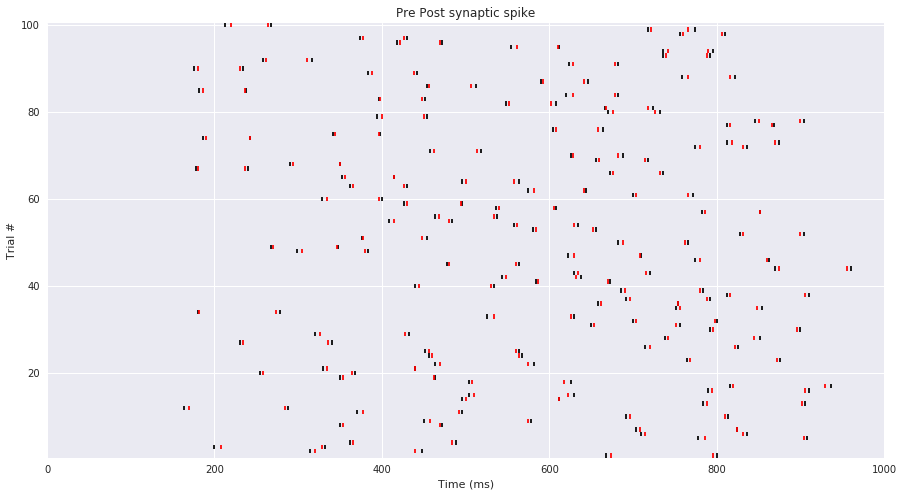

In [31]:
fig = plt.figure(figsize=(15, 8))
trial_length = np.arange(0,10)
ax = raster(loci_pre_2[:100], trial_length)
ax = raster(loci_post_2[:100], trial_length, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
plt.xlim([0,1000])
fig.show()

In [ ]:
input_quad = np.load('/data/Quad_toy_input.npy')
input_stdp.shape